# MsTMIP Data Extraction and Plotting

_Dan Krofcheck, Jan 2016_

## Overview
  
The MsTMIP (Multi-scale Synthesis and Terrestrial Model Intercomparison Project) prescribes a consistent set of meterological drivers across a range of land surface models, thus promoting model output intercomparison. 

To access and begin to analyze the model output, I've created the following workflow which is still highly WIP. In order to parse the netCDF4 files, I'm using netcdf4python (https://github.com/Unidata/netcdf4-python), which I'm pairing with spatial libraries gdal, ogr, and matplotlib's basemap.

The overall workflow is to read in a MsTMIP netCDF file, and parse it into a dict. Then, we can query the data at specific locations, in this case described in an ESRI shapefile. One challenge however is that the 1D array of lat and lon corrdinates in the MsTMIP data are distributed at 0.5 degree intervals. Therefore, selecting the closest pixel to any given lat long coordinate requires some rounding. Here, we simply select the lat and lon coordinates in each 1D array from the netCDF file which most closely matches our query lat and lon, and build up a second dict of analysis locations, and any other metadata included in the ESRI file such as a SITE ID. Then we simply drill into our data dict and extract a subset of temporal data for each pixel specified in our lat/lon list. Temporal subsets can be generated by passing extractData() a yearstart and yearstop variable.

The small suite of functions defined below should facilitate grabbing and plotting MsTMIP data output, and will become increasingly well commented in the near future. 

For more information about the MsTMIP project:

Ref: Huntzinger, D.N., C.R. Schwalm, Y. Wei, R.B. Cook, A.M. Michalak, K. Schaefer, A.R. Jacobson, M.A. Arain, P. Ciais, J.B. Fisher, D.J. Hayes, M. Huang, S. Huang, A. Ito, A.K. Jain, H. Lei, C. Lu, F. Maignan, J. Mao, N. Parazoo, C. Peng, S. Peng, B. Poulter, D.M. Ricciuto, H. Tian, Xiaoying Shi, W. Wang, N. Zeng, F. Zhao, and Q. Zhu (in press). NACP MsTMIP: Global 0.5-deg Terrestrial Biosphere Model Outputs (version 1) in Standard Format. Data set. Available on-line [http://daac.ornl.gov] from Oak Ridge National Laboratory Distributed Active Archive Center, Oak Ridge, Tennessee, USA. DOI: 10.3334/ORNLDAAC/1225.

## Load required libraries
This is probably overkill. Need to thin down and update the libraries used both in the data generation and plotting. Currently spitting out some warnings, given the deprication of some of the packages involved. 

Basically I'm using netCDF4 and netcdftime to handle all of the .nc4 peculiarities and gdal + ogr to both read in query locations from an esri shapefile and plot the result over a basemap with Basemap.

Plotting and data handling are dealt with using numpy and Pandas + matplotlib. 

I would like to add some functions or a class that produces better looking maps, thinking shapely or kartograph.

In [12]:
# Jupyter notebook required magics for plotting inline
%matplotlib inline

# NetCDF and timestamp libraries
from netCDF4 import Dataset as NetCDFFile
from netcdftime import utime
from datetime import datetime
import sys

# Spatial
import gdal, ogr
from mpl_toolkits.basemap import Basemap, shiftgrid

# Analysis, formatting, and plotting
import numpy as np
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import clear_output

# Specify input and output directories
#dataDir = '/home/nikko/Research/MsTMIP/Data/'
dataDir = '/media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/'
outputDir = '/home/nikko/Research/MsTMIP/output/'

# Specify query locations -- here loaded as an ESRI shape file
locs = '/home/nikko/Research/MsTMIP/Shape/SW_Synth_locs.shp'

<h3>
Define functions 
</h3>

Simple functions here, first to read the file that contains the site locations (ESRI shapefile), a couple functions to get the x and y location given a lat and long value (finding the closest pixel to an arbitrary geospatial location), a helper function to build the list of pixel locations, and some functions to parse and assign time stamps to the .nc4 files. Finally, building a pandas dataframe by drilling into one of the MsTMIP rasters.

In [13]:
# Function definition

# Read in the shape file containing the query locations,
# and output some useful metadata
def readQueryFile(filename):
    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.Open(filename, 0)
    
    # Check to see if shapefile is found.
    if ds is None:
        print 'Could not open %s' % (locs)
    else:
        print 'Opened %s' % (locs)
        lyr = ds.GetLayer()
        featureCount = lyr.GetFeatureCount()
        print "Number of features in %s: %d" % (os.path.basename(locs),featureCount)

    layerDefinition = lyr.GetLayerDefn()

    print "Contains the following user defined field names:"
    print "-----------------"
    for i in range(layerDefinition.GetFieldCount()):
        print  layerDefinition.GetFieldDefn(i).GetName()
    print "-----------------"
    return(ds)
        
# Find the nearest value in an array to any given value. Used for
# selecting the lat / long grid cell which contains the point locations
# in the query shape.
def locatePixel(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Given an input shapefile of lat/long coordinates, extract
# a list of pixel locations associated with each point.
# Append to the list the data from an ID field in the
# query file. readQueryFile() prints a list of field names
# to make this simpler.
def makePixelList(layer, latArray, lonArray, ID):
    toExtract = []
    for feat in layer:
        geom = feat.GetGeometryRef()
        IDfield = feat.GetField(ID)
        mx,my=geom.GetX(), geom.GetY()  #coord in map units
        latID = locatePixel(latArray, my)
        lonID = locatePixel(lonArray, mx)
        toExtract.append([lonID, latID, IDfield])
    extractDict = dict(Lons = zip(*toExtract)[0],Lats = zip(*toExtract)[1],
                       IDFields = zip(*toExtract)[2])
    return extractDict

# Read in a MsTMIP NetCDF file, returning the associated variables of interest
# as an array. Each file contains a 1D array of lattitudes, longitudes, time,
# and some model output (e.g., GPP, NEE, etc.). Given the consistent convention
# of the filenames, we can also parse the data to retrieve the model name, 
# simulation name, and the model output name. This information is returned
# in the form of a dictionary.
def parseNetCDF(filename):
    split1 = filename.split("/")[len(filename.split("/")) - 1]
    split2 = split1.split("_")[3]
    split3 = split2.split(".")
    modelVar = split3[0]
    modelName = split1.split("_")[0]
    simName = split1.split("_")[1]
    
    nc = NetCDFFile(filename)
    lats = nc.variables['lat']
    lons = nc.variables['lon']
    times = nc.variables['time']
    datavar = nc.variables[modelVar]
    toOutput = dict(Lats = lats, 
                    Lons = lons, 
                    Times = times, 
                    Data = datavar, 
                    ModelName = modelName, 
                    SimName = simName, 
                    ModelVar = modelVar)
    return toOutput

# Helper function to generate the interval of data in a netCDF
# file that corresponds with a year start and year stop. Given that
# the data are produced as center averaged monthly data, year
# start and stop dates are specified as Jan and Dec 15 of 
# the corresponding years respectively.
def timeInterval(dataDict, yearStart, yearStop):
    cdftime = utime('days since 1700-01-01 00:00:00')
    datestart = cdftime.date2num(datetime(yearStart, 1, 15))
    datestop = cdftime.date2num(datetime(yearStop, 12, 15))
    idxStart = np.where(dataDict['Times'][:] == datestart)
    idxStop = np.where(dataDict['Times'][:] == datestop)
    return idxStart[0][0], idxStop[0][0]

# Drill into the netCDF data and extract the time series of data
# for the given lat and lon coordinates generated from the query file.
# The function now returns a pandas dataframe.
def extractData(dataDict, outputDict, pixmap, yearStart, yearStop):
    # Initialize 2 empty variables, one which will establish the pandas dataframe
    # structure, and the other which will grow with time -- this needs to be improved.
    outputDict = []
    outputDict_concat = []
    dateStr = []
    
    cdftime = utime('days since 1700-01-01 00:00:00')
    start, stop = timeInterval(dataDict, yearStart, yearStop)
    times = cdftime.num2date(dataDict['Times'][start:stop])
    
    # Create an array of datetime strings
    for time in times:
        dateStr.append((time).strftime('%Y%m%d'))
    
    for pixel in np.arange(0,len(pixmap['IDFields'])):
        xx = np.where(dataDict['Lons'][:] == pixMap['Lons'][pixel])[0][0]
        yy = np.where(dataDict['Lats'][:] == pixMap['Lats'][pixel])[0][0]
        if pixel == 0:
            outputDict = pd.DataFrame(dict(Data = dataDict['Data'][start:stop,yy,xx]))
            outputDict['Date'] = dateStr 
            outputDict['Site'] = pixMap['IDFields'][pixel]
            outputDict['Lon'] = pixMap['Lons'][pixel]
            outputDict['Lat'] = pixMap['Lats'][pixel]
            outputDict['ModelName'] = dataDict['ModelName']
            outputDict['SimName'] = dataDict['SimName']
            outputDict['ModelVar'] = dataDict['ModelVar']
        else:
            outputDict_concat = pd.DataFrame(dict(Data = dataDict['Data'][start:stop,yy,xx]))
            outputDict_concat['Date'] = dateStr 
            outputDict_concat['Site'] = pixMap['IDFields'][pixel]
            outputDict_concat['Lon'] = pixMap['Lons'][pixel]
            outputDict_concat['Lat'] = pixMap['Lats'][pixel]
            outputDict_concat['ModelName'] = dataDict['ModelName']
            outputDict_concat['SimName'] = dataDict['SimName']
            outputDict_concat['ModelVar'] = dataDict['ModelVar']
            
            outputDict = outputDict.append(outputDict_concat)
            
    return outputDict

### Generate a dataframe from a directory full of MsTMIP data
Here, the input data structure is basically a hopper full of .nc4 files. There is currently no directory structure for the input data -- its just all in one folder. The way we handle the resulting data frame sorts this out, but it might be nice to build some more structure into the input data, just for organizational reasons.

In [14]:
# Generate our file list over which to iterate
fileList = glob.glob(dataDir + '*.nc4')
listLength = len(fileList)
count = 0
outputDict = []


# Iterate through the list of files in our data directory, each file
# represents a single model run
for filename in fileList:
    
    # Read in the netCDF file
    dataDict = parseNetCDF(filename)
    print 'reading ' + filename
    #print %d of %d (%, count, listLength)
    sys.stdout.flush()

    # If this is the first iteration of the loop, initialize the shapefile data
    # which maps lat long to element location in the netCDF data.
    if count == 0:
        # Load our query file (shapefile) and establish our pixel mapping
        ds = readQueryFile(locs)
        layer = ds.GetLayer()
        pixMap = makePixelList(layer, dataDict['Lats'][:], dataDict['Lons'][:], 'Code')
        
        # Build the output dictionary
        outputDict = extractData(dataDict, outputDict, pixMap, 2000,2010)
        
    else:
        outputDict = outputDict.append(extractData(dataDict, outputDict, pixMap, 2000,2010))
    
    count = count + 1

# Quickly describe the forcing scenarios used in the model runs loaded into the output dict
data = pd.DataFrame(outputDict)
models = np.unique(data.ModelName)
sims = np.unique(data.SimName)
variables = np.unique(data.ModelVar)

print 'generating time stamps:'
data.index = pd.to_datetime(data.Date)
print '-----------------'
print str(min(data.index.year)) + ' through ' + str(max(data.index.year))
print '-----------------'

sites = np.unique(data.Site)

print '''

models included in the current dataframe:
-----------------'''
print models
print '-----------------'

print '''

simulation names included in the current dataframe:
-----------------'''
print sims
print '-----------------'

print '''

site codes included in the current dataframe:
-----------------'''
print sites
print '-----------------'

print '''

variables included in the current dataframe:
-----------------'''
print variables
print '-----------------'


reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/CLM4VIC_BG1_Monthly_NEE.nc4
Opened /home/nikko/Research/MsTMIP/Shape/SW_Synth_locs.shp
Number of features in SW_Synth_locs.shp: 32
Contains the following user defined field names:
-----------------
Code
Long
Lat
Elevation
-----------------
reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/ISAM_BG1_Monthly_Evap.nc4
reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/BIOME-BGC_BG1_Monthly_Evap.nc4
reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/BIOME-BGC_BG1_Monthly_GPP.nc4
reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/BIOME-BGC_BG1_Monthly_NEE.nc4
reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/BIOME-BGC_BG1_Monthly_NEP.nc4
reading /media/nikko/Seagate Backup Plus Drive/MsTMIP_Synthesis/VarsForSynthesis/BIOME-BGC_BG1_Monthly_NPP.nc4
reading /media/n

### Stepping through the data and generating ensembles
This is a rough cut effort to take a given site and generate ensemble means for the model runs within the given simulation (i.e., forcings). For the SW synthesis, we're going to stick to the NARR1 forcings, given the inclusion of land use change and nitrogen deposition -- but we may want to build on that in the future, so this should be a scalable aproach. 

#### Slicing and plotting
A couple more helper functions to pull out the data in manageable chunks, and facilitate averaging across models  now, simulations soon).

Workflow:
1) Site > Model > Variable > Simulation

Pull out data for each site, and within that ensemble all of the models by simulation and variable

In [15]:
data.ModelVar.unique()

array(['NEE', 'Evap', 'GPP', 'NEP', 'NPP', 'TotalResp'], dtype=object)

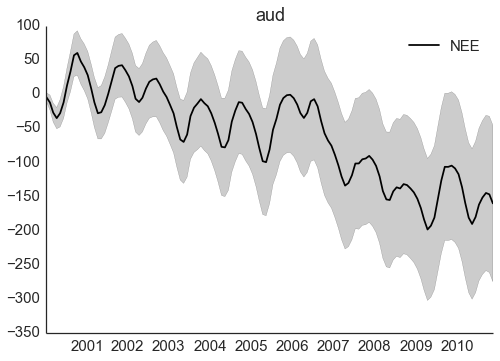

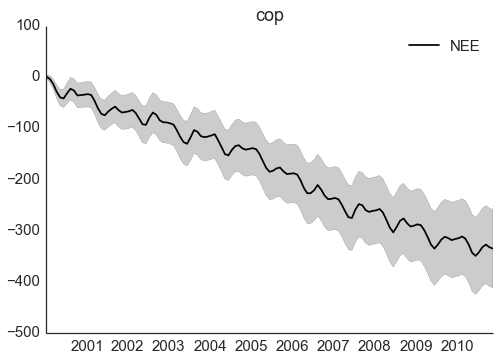

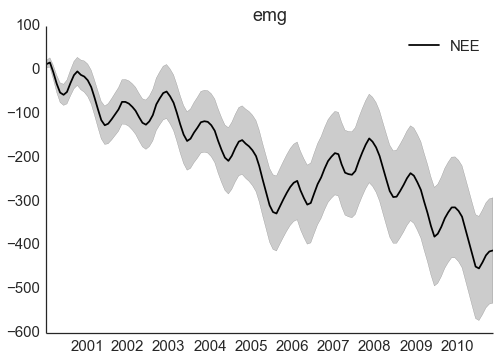

In [23]:
# Slice into the data by site first -- we have no interest in combining sites in the ensemble

# variable colors
varcolors = ['#ef8a62', '#1a9641', '#5e3c99']

sitesub = sites[:3]
for site in sitesub:
    plt.figure()
    coloridx = 0
    # Nor do we have any interest in combining variables -- Site and Variable will be our plotting
    # facets or out table columns
    sitesub = data[data.Site == site]
    modelsub = sitesub[sitesub.ModelVar == 'NEE']

    # Calculate mean and std of the resulting sliced data -- this should include
    # all of the models and simulations described by the function params above

    # Make Respiration negative for plotting
    ensembleDataMu = modelsub.groupby([modelsub.index,'ModelVar']).mean().reset_index()
    ensembleDataStd = modelsub.groupby([modelsub.index,'ModelVar']).std().reset_index()

    ensembleDataMu.index = pd.to_datetime(ensembleDataMu.Date)
    ensembleDataStd.index = pd.to_datetime(ensembleDataMu.Date)
    x = ensembleDataMu.index
    # ---- Units are g/m2/month
    mu = ensembleDataMu.Data.cumsum() * 1000 * 2.62 * 10**(6) # Converting kg to g, and seconds to months
    sigma = ensembleDataStd.Data.cumsum() * 1000 * 2.62 * 10**(6)
    plt.plot(x, mu, color = 'black', alpha = 1)
    plt.fill_between(x, mu - 2*np.sqrt(sigma), mu + 2*np.sqrt(sigma), 
                     facecolor = 'gray', alpha = 0.4)
    plt.title(site)
    plt.legend(['NEE'])
    plt.grid('off')
    sns.despine()
    sns.set_style('white')
    sns.set_context('notebook', font_scale=1.5)

### Tabular output
Generate wide format CSV of the ensembled output. Need to wrap up in a function. Also need to generate a metadata csv which describes the contents of each column's ensemble, both in terms of the models and simulations used to generate the data. The metadata needs to be generated automatically from the inputs to the function that spits out the csv.

In [26]:
def ensembleDataGen(inputs):
    #placeholder
    return null

modelEnsemble = data.groupby([data.index, 'Site','ModelVar']).mean().reset_index()
modelEnsembleVar = data.groupby([data.index, 'Site','ModelVar']).var().reset_index()

modelEnsemble.index = pd.to_datetime(modelEnsemble.Date)
modelEnsembleVar.index = pd.to_datetime(modelEnsembleVar.Date)
idx = 0
for site in sites:
    sub_s = modelEnsemble[modelEnsemble.Site == site]
    subVar_s = modelEnsembleVar[modelEnsembleVar.Site == site]
    GPP_Mu = sub_s[sub_s.ModelVar == 'GPP']
    GPP_Var = subVar_s[subVar_s.ModelVar == 'GPP'].Data
    NEE_Mu = sub_s[sub_s.ModelVar == 'NEE'].Data
    NEE_Var = subVar_s[subVar_s.ModelVar == 'NEE'].Data
    NEP_Mu = sub_s[sub_s.ModelVar == 'NEP'].Data
    NEP_Var = subVar_s[subVar_s.ModelVar == 'NEP'].Data
    NPP_Mu = sub_s[sub_s.ModelVar == 'NPP'].Data
    NPP_Var = subVar_s[subVar_s.ModelVar == 'NPP'].Data
    Evap_Mu = sub_s[sub_s.ModelVar == 'Evap'].Data
    Evap_Var = subVar_s[subVar_s.ModelVar == 'Evap'].Data
    TotalResp_Mu = sub_s[sub_s.ModelVar == 'TotalResp'].Data
    TotalResp_Var = subVar_s[subVar_s.ModelVar == 'TotalResp'].Data

    if idx == 0:
        ensembleData = pd.DataFrame(dict(Date = GPP_Mu.Date, Site = GPP_Mu.Site, 
                          GPP_Mu = GPP_Mu.Data, GPP_Var = GPP_Var,
                          NEE_Mu = NEE_Mu, NEE_Var = NEE_Var,
                          NEP_Mu = NEP_Mu, NEP_Var = NEP_Var, 
                          NPP_Mu = NPP_Mu, NPP_Var = NPP_Var, 
                          TotalResp_Mu = TotalResp_Mu, TotalResp_Var = TotalResp_Var, 
                          Evap_Mu = Evap_Mu, Evap_Var = Evap_Var,
                          Lon = GPP_Mu.Lon, Lat = GPP_Mu.Lat))
    else:
        nextSite = pd.DataFrame(dict(Date = GPP_Mu.Date, Site = GPP_Mu.Site, 
                          GPP_Mu = GPP_Mu.Data, GPP_Var = GPP_Var,
                          NEE_Mu = NEE_Mu, NEE_Var = NEE_Var,
                          NEP_Mu = NEP_Mu, NEP_Var = NEP_Var, 
                          NPP_Mu = NPP_Mu, NPP_Var = NPP_Var, 
                          TotalResp_Mu = TotalResp_Mu, TotalResp_Var = TotalResp_Var,
                          Evap_Mu = Evap_Mu, Evap_Var = Evap_Var,
                          Lon = GPP_Mu.Lon, Lat = GPP_Mu.Lat))
        ensembleData = pd.concat([ensembleData, nextSite])
    idx = idx + 1
    
# Write the ensembled data to csv
ensembleData.to_csv('EnsembledOutput.csv',index = False, columns = ['Date','Site','Lon','Lat',
                                                                   'GPP_Mu','GPP_Var','NEE_Mu','NEE_Var',
                                                                   'NEP_Mu','NEP_Var', 'NPP_Mu','NPP_Var',
                                                                   'Evap_Mu','Evap_Var',
                                                                   'TotalResp_Mu','TotalResp_Var'])

# Genreate metadata
def metaDataGen():
    #placeholder
    #return metadata
    return null

<h3>
Produce a quick and dirty map, showing a slice of the MsTMIP data, and the query locations
</h3>

(31, 1, [-117.695943, 24.1293, 0.0, 0.0], [-105.0917, 40.032859, 0.0, 0.0])


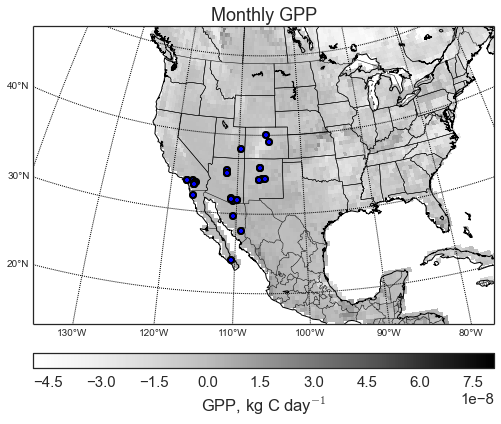

In [15]:
import shapefile
locs = '/home/nikko/Research/MsTMIP/Shape/tower_locs'
sns.set_style('white')

GPP = dataDict['Data'][400]
latcorners = dataDict['Lats'][:]
loncorners = -dataDict['Lons'][:]

lats = dataDict['Lats'][:]
lons = dataDict['Lons'][:]
# create figure and axes instances
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# Get some parameters for the Stereographic Projection
lon_0 = lons.mean()
lat_0 = lats.mean()

m = Basemap(width=6500000,height=4200000,
            resolution='l',projection='stere',\
            lat_ts=35.,lat_0=35,lon_0=-106)
# Because our lon and lat variables are 1D, 
# use meshgrid to create 2D arrays 
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

cs = m.pcolor(xi,yi,np.squeeze(GPP))

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()


sites_info = m.readshapefile(locs, 'sites')

print sites_info

for info, sites in zip(m.sites_info, m.sites):
    m.plot(sites[0], sites[1], marker='o', color='b', markersize=6, markeredgewidth=2)

cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('GPP, kg C day$^{-1}$')

# Add Title
plt.title('Monthly GPP')
plt.savefig('ExampleMap.tiff')
